In [ ]:
import os
import shutil #shell utilities.
import random

SOURCE_DIR = "D:\\Studies\\Deep_Learning\\Cotton_Original_Dataset"   # original dataset folder
OUTPUT_DIR = "dataset_split"

TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

random.seed(42)

for class_name in os.listdir(SOURCE_DIR):
    class_path = os.path.join(SOURCE_DIR, class_name)

    if os.path.isdir(class_path):

        images = os.listdir(class_path)
        random.shuffle(images)

        total = len(images)
        train_end = int(total * TRAIN_RATIO)
        val_end = int(total * (TRAIN_RATIO + VAL_RATIO))

        train_images = images[:train_end]
        val_images = images[train_end:val_end]
        test_images = images[val_end:]

        for split, split_images in zip(
            ["train", "val", "test"],
            [train_images, val_images, test_images]
        ):
            split_dir = os.path.join(OUTPUT_DIR, split, class_name)
            os.makedirs(split_dir, exist_ok=True)

            for img in split_images:
                shutil.copy(
                    os.path.join(class_path, img),
                    os.path.join(split_dir, img)
                )

print("Dataset successfully split into train / val / test!")


Dataset successfully split into train / val / test!


In [20]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np



Batch size = number of training samples processed before the model updates its weights once.

In [28]:
# CONFIGURATION
IMG_SIZE = 224 
BATCH_SIZE = 32
EPOCHS = 13
train_dir = "dataset_split/train" 
val_dir = "dataset_split/val"


Data augmentation is a regularization technique that increases dataset diversity by applying random transformations to training images, helping prevent overfitting and improving model generalization.

In [ ]:
# DATA AUGMENTATION

from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2]
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  #For evaluation always shuffle=False
)



Found 959 images belonging to 5 classes.


Found 207 images belonging to 5 classes.


Am used a pretrained ResNet50 model with ImageNet weights as a feature extractor. The top classification layers were removed and replaced with custom layers for our 5 classes. The base model was frozen to preserve pretrained features and reduce overfitting.

In [30]:
# LOAD PRETRAINED RESNET50
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False  # Freeze base model



Am used ResNet50 as a pretrained feature extractor, followed by global average pooling and a fully connected classifier with dropout. The model was compiled with Adam optimizer and categorical crossentropy for multi-class classification.

In [39]:
# BUILD MODEL
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,629 (90.98 MB)

 Trainable params: 262,917 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Class weights were computed using a balanced strategy to handle class imbalance. This ensures that minority classes contribute more to the loss function, preventing the model from being biased toward majority classes.

In [40]:
from sklearn.utils.class_weight import compute_class_weight 
import numpy as np 
classes = train_generator.classes 
class_weights = compute_class_weight( class_weight='balanced', classes=np.unique(classes), y=classes ) 
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: np.float64(1.5851239669421489), 1: np.float64(1.2618421052631579), 2: np.float64(0.8161702127659575), 3: np.float64(0.8231759656652361), 4: np.float64(0.8798165137614679)}


In [42]:
# TRAIN MODEL
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights_dict
)

Epoch 1/13
30/30 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.8342 - loss: 0.4902 - val_accuracy: 0.8792 - val_loss: 0.3170
Epoch 2/13
30/30 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.8770 - loss: 0.3710 - val_accuracy: 0.9082 - val_loss: 0.2651
Epoch 3/13
30/30 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.8968 - loss: 0.2992 - val_accuracy: 0.9034 - val_loss: 0.2970
Epoch 4/13
30/30 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9041 - loss: 0.2948 - val_accuracy: 0.8937 - val_loss: 0.2659
Epoch 5/13
30/30 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9103 - loss: 0.2595 - val_accuracy: 0.9227 - val_loss: 0.1847
Epoch 6/13
30/30 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9124 - loss: 0.2287 - val_accuracy: 0.8937 - val_loss: 0.2228
Epoch 7/13
30/30 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9208 - loss: 0.2347 - val_accuracy: 0.9082 - val_loss: 0.2306
Epoch 8/13
30/30 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9239 - loss: 0.1993 - val_accuracy: 0.9082 - val_loss:

In [43]:
# EVALUATION
val_generator.reset()
preds = model.predict(val_generator)
y_pred = np.argmax(preds, axis=1)

print("Classification Report:")
print(classification_report(val_generator.classes, y_pred, target_names=val_generator.class_indices.keys()))

7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
Classification Report:
                      precision    recall  f1-score   support

Alternaria Leaf Spot       1.00      0.85      0.92        26
    Bacterial Blight       0.74      0.94      0.83        33
       Fusarium Wilt       0.94      0.90      0.92        51
        Healthy Leaf       1.00      1.00      1.00        50
   Verticillium Wilt       0.91      0.85      0.88        47

            accuracy                           0.91       207
           macro avg       0.92      0.91      0.91       207
        weighted avg       0.92      0.91      0.91       207



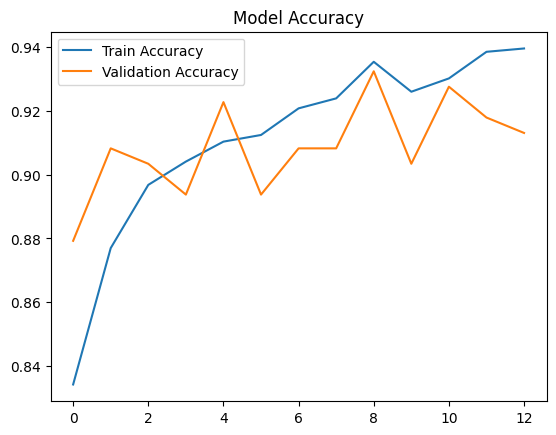

In [44]:
# PLOT ACCURACY
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()

In [38]:
# SAVE MODEL
model.save("cotton_disease_resnet50.h5")